In [75]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt


## Example dimension calculation function
def variation_dim(X, order=1):
    # Implements the order p variation fractal dimension from https://arxiv.org/pdf/1101.1444.pdf (eq 18)
    # order 1 corresponds to the madogram, 2 to the variogram, 1/2 to the rodogram
    return 2 - 1 / (order * np.log(2)) * (np.log(power_var(X, 2, order)) - np.log(power_var(X, 1, order)))

# Helper function
def power_var(X, l, ord):
    # The power variation, see variation_dim
    diffs = X[l:] - X[:-l]
    norms = np.zeros(diffs.shape[0])
    for i, d in enumerate(diffs):
        norms[i] = np.linalg.norm(d, ord=1)

    return 1 / (2 * len(X) - l) * np.sum(norms)



## Example dimension calculation function
def mesh_dim(data, scaling_factor=1.5, init_d=1e-2, upper_size_ratio=4/5, lower_size_ratio=0.0, d_limit=1e-9):
    """
    Args:
        data - any array like, represents the trajectory you want to compute the dimension of
        scaling factors - float indicating how much to scale d by for every new mesh
        init_d - float, initial box size
        upper_size_ratio - upper_size_ratio*data.shape[0] determines what size of mesh to stop at when finding the upper bound of the curve.
        lower_size_ratio - lower_size_ratio*data.shape[0] determines what size of mesh to stop at when finding the lower bound of the curve. Usually best to leave at 0.
        d_limit - smallest d value to allow when seeking the upper_size bound

    Returns:
        mdim: linear fit to the log(mesh) log(d) data, intentional underestimate of the meshing dimensions
        cdim: the conservative mesh dimension, that is the largest slope from the log log data, an intentional overestimate of the
        mesh_sizes: sizes of each mesh created during the computation
        d_vals: box sizes used to create each mesh during the computation
    """

    mesh_size_upper = np.round(upper_size_ratio * data.shape[0])
    mesh_size_lower = np.round(np.max((1.0, lower_size_ratio * data.shape[0])))
    d = init_d

    mesh = create_box_mesh(data, d)
    mesh_sizes = [len(mesh)]
    d_vals = [d]

    while mesh_sizes[0] < mesh_size_upper and d > d_limit:
        d /= scaling_factor
        mesh = create_box_mesh(data, d)
        mesh_sizes.insert(0, len(mesh))
        d_vals.insert(0, d)

    d = init_d
    while mesh_sizes[-1] > mesh_size_lower and d > d_limit:
        d = d * scaling_factor
        mesh = create_box_mesh(data, d)
        mesh_sizes.append(len(mesh))
        d_vals.append(d)

    for i, m in enumerate(mesh_sizes):
        if m < mesh_size_upper:
            lin_begin = i
            break

    xdata = np.log2(d_vals[lin_begin:])
    ydata = np.log2(mesh_sizes[lin_begin:])

    # Fit a curve to the log log line
    def f(x, m, b):
        return m * x + b

    popt, pcov = opt.curve_fit(f, xdata, ydata)

    # find the largest slope
    min_slope = 0
    for i in range(len(ydata) - 2):
        slope = (ydata[i+1] - ydata[i]) / (xdata[i + 1] - xdata[i])
        if slope < min_slope:
            min_slope = slope

    return -popt[0], -min_slope, mesh_sizes, d_vals


def create_box_mesh(data, d, initial_mesh=None):
    """ Creates a mesh from the given data using boxes of size d
    Args:
        data: np.array, the data you want to create a mesh for
        d: float, the length of the box used to determine membership in the mesh
        initial_mesh: dict, output from a previous call to create_box_mesh, used to add to a mesh rather than build a new one
    Returns:
        mesh: dict, keys are the mesh point coordinates, values are how many points in the original data set are represented by the mesh point
    """
    if initial_mesh is None:
        initial_mesh = {}

    mesh = initial_mesh
    data = np.asarray(data)

    scale = 1 / d

    keys = np.round(data * scale, decimals=0) * d
    keys[keys == -0.0] = 0.0

    for key in keys:
        key = tuple(key)
        if key in mesh:
            mesh[key] += 1
        else:
            mesh[key] = 1

    return mesh

In [53]:
def jessdim(X, optional_argument=None):
    # Write some new code here
    return 0

Rodogram: 1.995768029464667
Madogram: 1.9978840147323333
Variogram: 1.9989420073661668
Optimistic Mesh Dim: 4.977416566765821
New dimension: 0


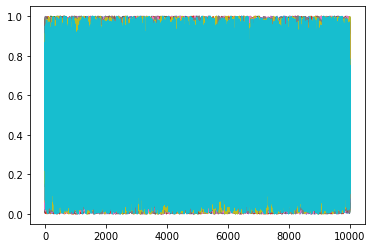

In [83]:
# Uniform random
X = np.random.random((10000,10))

plt.plot(X)

print(f"Rodogram: {variation_dim(X, order=.5)}")
print(f"Madogram: {variation_dim(X, order=1)}")
print(f"Variogram: {variation_dim(X, order=2)}")
print(f"Optimistic Mesh Dim: {mesh_dim(X)[0]}")
print(f"New dimension: {jessdim(X)}")

Rodogram: 1.9983742996288347
Madogram: 1.9991871498144174
Variogram: 1.9995935749072087
Optimistic Mesh Dim: 5.213615073338442
New dimension: 0


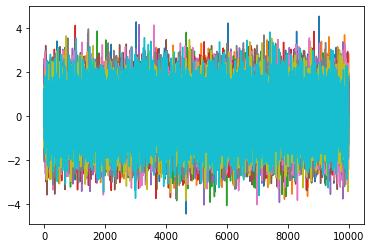

In [97]:
# Guassian random
X = np.random.standard_normal(size=(10000, 10))

plt.plot(X)

print(f"Rodogram: {variation_dim(X, order=.5)}")
print(f"Madogram: {variation_dim(X, order=1)}")
print(f"Variogram: {variation_dim(X, order=2)}")
print(f"Optimistic Mesh Dim: {mesh_dim(X)[0]}")
print(f"New dimension: {jessdim(X)}")

Rodogram: 0.0014459470058971746
Madogram: 1.0007229735029486
Variogram: 1.5003614867514743
Optimistic Mesh Dim: 0.88241856446217
New dimension: 0


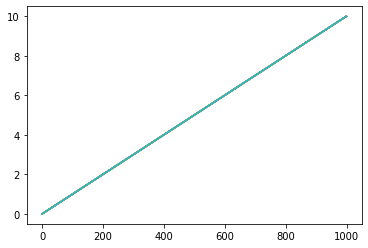

In [84]:
# Literally a line
X = np.linspace(np.zeros(10) ,np.ones(10)*10,1000)
plt.plot(X)

print(f"Rodogram: {variation_dim(X, order=.5)}")
print(f"Madogram: {variation_dim(X, order=1)}")
print(f"Variogram: {variation_dim(X, order=2)}")
print(f"Optimistic Mesh Dim: {mesh_dim(X)[0]}")
print(f"New dimension: {jessdim(X)}")